**1.Importing Necessary Libraries:**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from joblib import dump

**2.Load and Explore the Dataset:**

In [2]:
# Load dataset
df = pd.read_csv(
    "household_power_consumption.txt",
    sep=";",
    low_memory=False,
    na_values=["?"]
)

# Preview the data
print(" Dataset Shape:", df.shape)
print("\n Columns:\n", df.columns.tolist())
print("\n Info:")
print(df.info())

 Dataset Shape: (2075259, 9)

 Columns:
 ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB
None


**3.Basic Cleaning & Datetime Conversion:**

In [3]:
# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Drop original Date and Time columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Reorder columns
df = df[['Datetime'] + [col for col in df.columns if col != 'Datetime']]

# Convert numeric columns to float
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check missing values
print("\n Missing Values:\n", df.isnull().sum())


 Missing Values:
 Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


**4.Exploratory Data Analysis (EDA):**

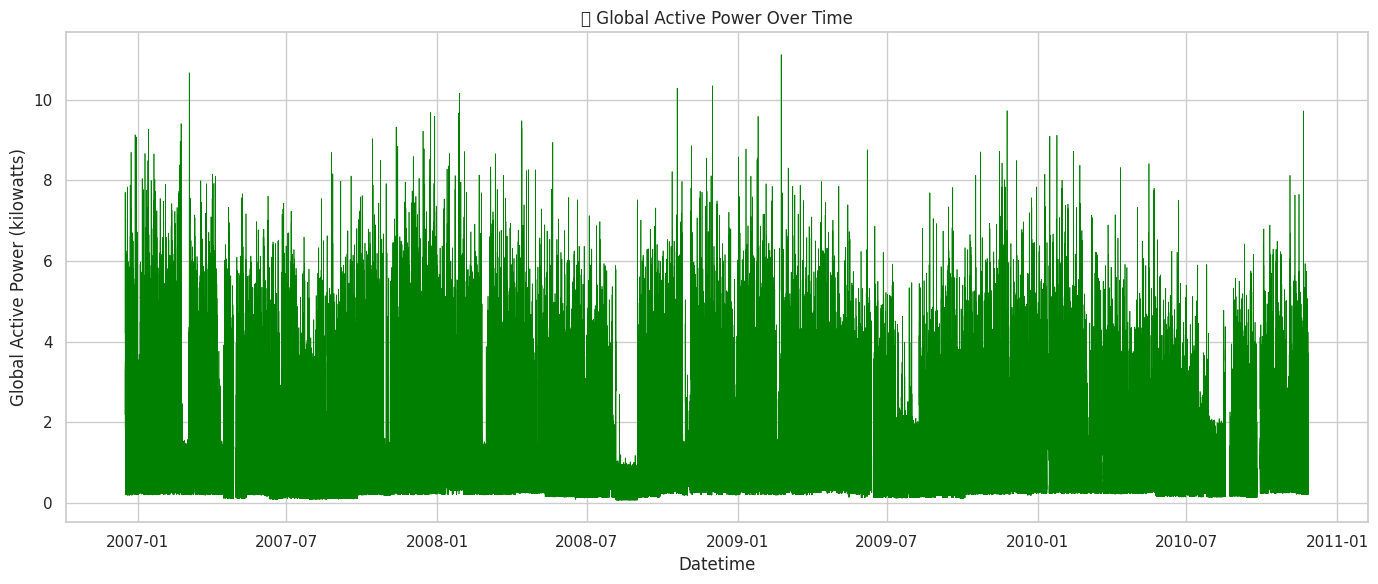

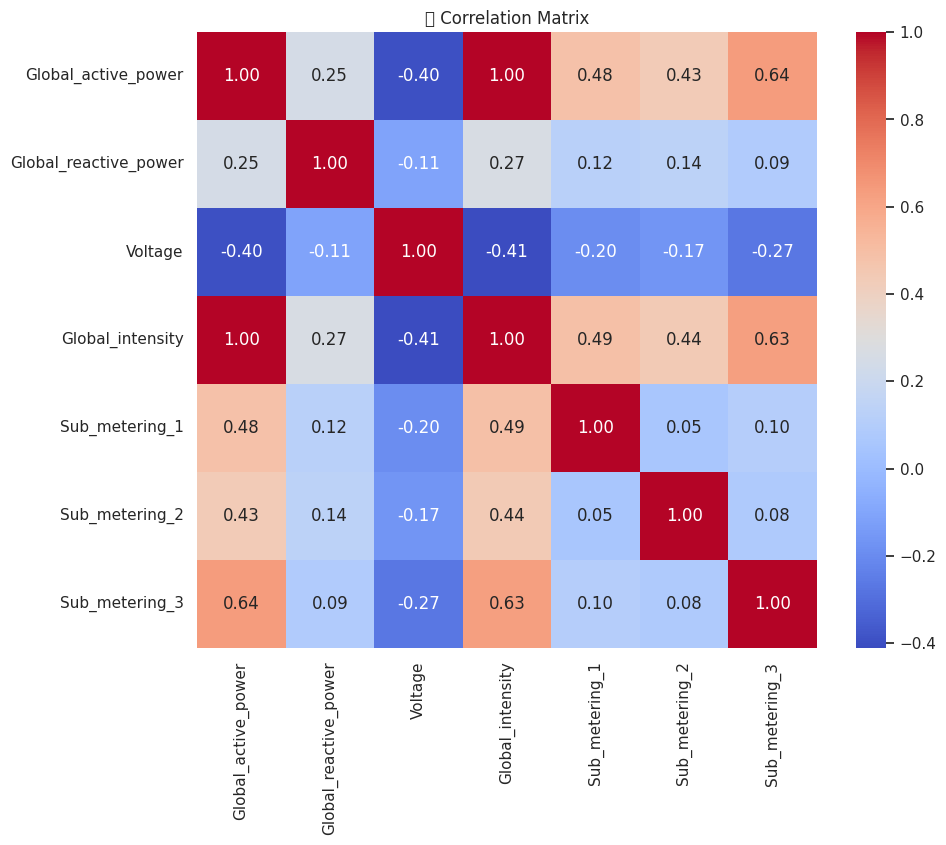

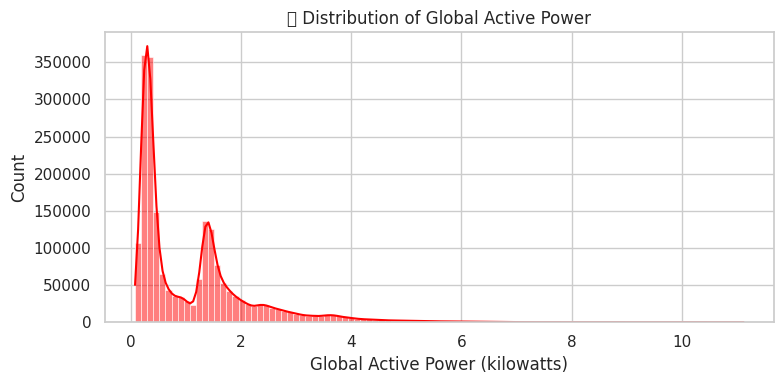

In [4]:
# Set style
sns.set(style="whitegrid")

# Plot Global Active Power over time
plt.figure(figsize=(14, 6))
plt.plot(df['Datetime'], df['Global_active_power'], color='Green', linewidth=0.5)
plt.title("📈 Global Active Power Over Time")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kilowatts)")
plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = df.drop(columns=["Datetime"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Correlation Matrix")
plt.show()

# Distribution of Global Active Power
plt.figure(figsize=(8, 4))
sns.histplot(df['Global_active_power'].dropna(), bins=100, kde=True, color='Red')
plt.title("🔍 Distribution of Global Active Power")
plt.xlabel("Global Active Power (kilowatts)")
plt.tight_layout()
plt.show()

**5.Detecting Outliers with IQR Method:**

In [5]:
# Detecting outliers in Global_active_power
q1 = df['Global_active_power'].quantile(0.25)
q3 = df['Global_active_power'].quantile(0.75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
outliers = df[(df['Global_active_power'] < lower_bound) | (df['Global_active_power'] > upper_bound)]

print("Number of Outliers Detected in 'Global_active_power':", len(outliers))

Number of Outliers Detected in 'Global_active_power': 94907


In [6]:
print("Summary:")

print(f"- Total records: {len(df)}")
print(f"- Columns with missing values: {df.isnull().sum()[df.isnull().sum() > 0].to_dict()}")
print(f"- Global Active Power range: {df['Global_active_power'].min()} to {df['Global_active_power'].max()}")
print(f"- Strong correlations: \n{corr_matrix['Global_active_power'].sort_values(ascending=False)}")

Summary:
- Total records: 2075259
- Columns with missing values: {'Global_active_power': 25979, 'Global_reactive_power': 25979, 'Voltage': 25979, 'Global_intensity': 25979, 'Sub_metering_1': 25979, 'Sub_metering_2': 25979, 'Sub_metering_3': 25979}
- Global Active Power range: 0.076 to 11.122
- Strong correlations: 
Global_active_power      1.000000
Global_intensity         0.998889
Sub_metering_3           0.638555
Sub_metering_1           0.484401
Sub_metering_2           0.434569
Global_reactive_power    0.247017
Voltage                 -0.399762
Name: Global_active_power, dtype: float64


**6.Handling the missing values:**

In [7]:
missing_percent = df.isnull().mean() * 100
print(missing_percent)

Datetime                 0.000000
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64


In [8]:
df.duplicated().sum()

0

In [9]:
df.fillna(method='ffill', inplace=True)

**7.Feature Engineering:**

In [10]:
# Extract useful time-based features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['month'] = df['Datetime'].dt.month
df['weekday'] = df['Datetime'].dt.dayofweek  # Monday=0

# Create Daily Average Global Active Power
df['date_only'] = df['Datetime'].dt.date
daily_avg = df.groupby('date_only')['Global_active_power'].mean().reset_index(name='daily_avg_global_active_power')
df = df.merge(daily_avg, on='date_only', how='left')

# Identify Peak Hours (e.g., 6 PM to 10 PM)
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# Rolling Average (3-hour window)
df['rolling_avg_power'] = df['Global_active_power'].rolling(window=3, min_periods=1).mean()

# Drop helper column
df.drop(columns=['date_only'], inplace=True)

<Axes: title={'center': 'Daily Energy Usage'}, xlabel='date_only'>

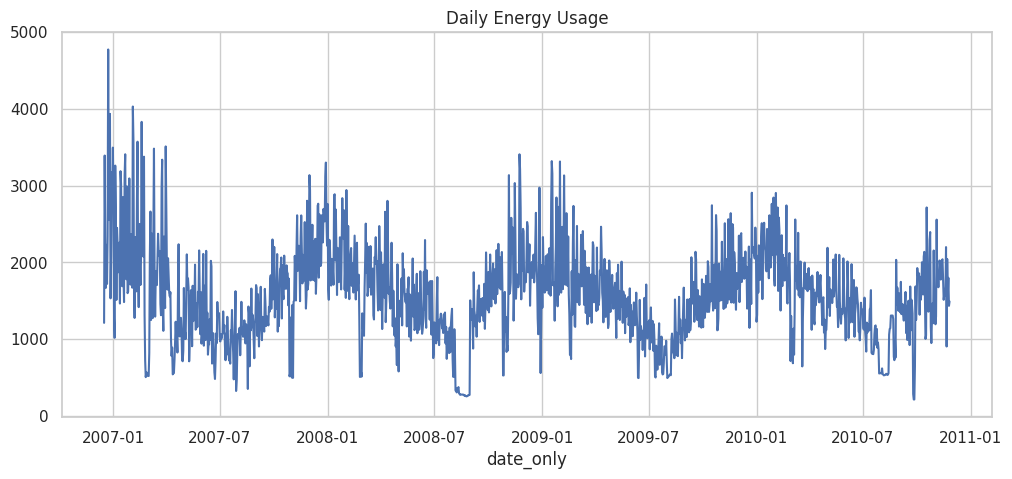

In [43]:
df['date_only'] = df['Datetime'].dt.date
daily_usage = df.groupby('date_only')['Global_active_power'].sum()

daily_usage.plot(figsize=(12, 5), title="Daily Energy Usage")

<Axes: title={'center': 'Avg Usage: Weekday vs Weekend'}>

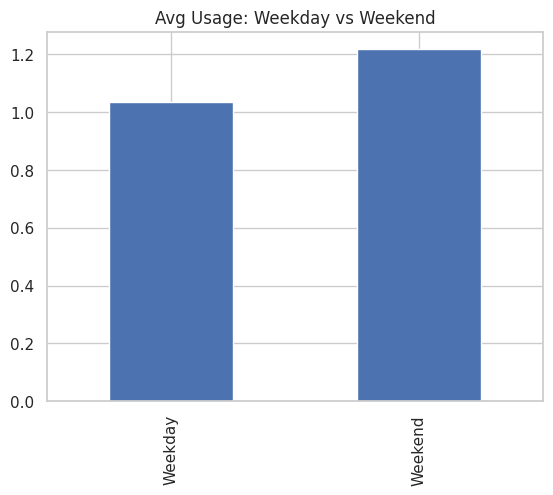

In [44]:
week_usage = df.groupby('is_weekend')['Global_active_power'].mean()
week_usage.index = ['Weekday', 'Weekend']

week_usage.plot(kind='bar', title='Avg Usage: Weekday vs Weekend')

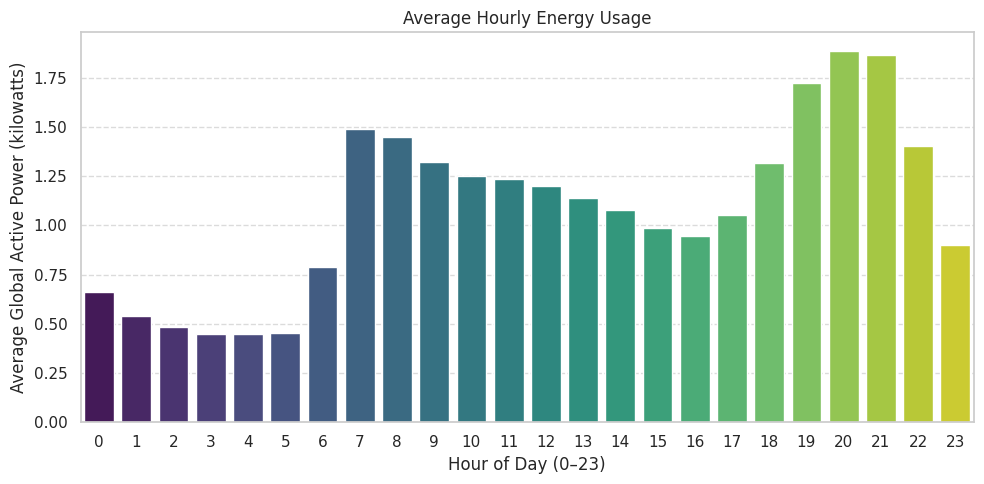

In [45]:
# Group by hour and calculate average usage
hourly_avg = df.groupby('hour')['Global_active_power'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_avg.index, y=hourly_avg.values, palette="viridis")

plt.title("Average Hourly Energy Usage")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Global Active Power (kilowatts)")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# Target Variable
target_col = 'Global_active_power'

# Input Features (from earlier steps)
feature_cols = [
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'hour',
    'weekday',
    'month',
    'is_peak_hour',
    'rolling_avg_power',
    'daily_avg_global_active_power'
]

X = df[feature_cols]
y = df[target_col]

**8.Model selection and Training:**

In [12]:
# X and y from feature engineering step
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
}

#  Store results
results = {}

#  Train & Evaluate
for name, model in models.items():
    print(f"\n Training {name}...")
    start = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    end = time.time()
    elapsed = round(end - start, 2)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "Time (s)": elapsed,
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    }

# Display Results
print("\n Model Performance Summary:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


 Training Linear Regression...

 Training Random Forest...

 Training Gradient Boosting...

 Model Performance Summary:

Linear Regression:
  Time (s): 1.96
  RMSE: 0.0395
  MAE: 0.025
  R²: 0.9986

Random Forest:
  Time (s): 200.64
  RMSE: 0.0314
  MAE: 0.0168
  R²: 0.9991

Gradient Boosting:
  Time (s): 82.46
  RMSE: 0.0399
  MAE: 0.0244
  R²: 0.9986


**9.Model Evaluation:**

In [15]:
# Convert results to DataFrame for better comparison
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")

print("\n📋 Model Evaluation Summary:")
display(results_df)


📋 Model Evaluation Summary:


,Time (s),RMSE,MAE,R²
Random Forest,200.64,0.0314,0.0168,0.9991
Linear Regression,1.96,0.0395,0.0250,0.9986
Gradient Boosting,82.46,0.0399,0.0244,0.9986


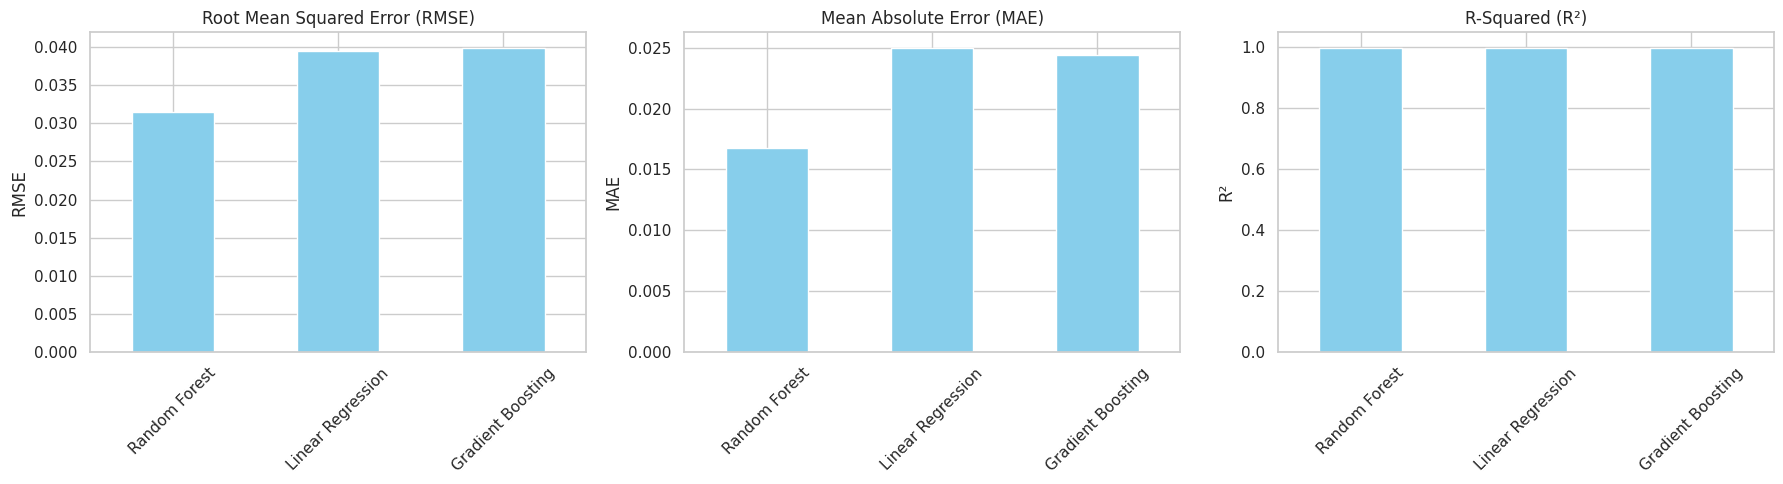

In [22]:
metrics = ['RMSE', 'MAE', 'R²']
titles = ['Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R-Squared (R²)']

plt.figure(figsize=(18, 5))  # Wide enough for 3 plots

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    results_df[metric].plot(kind='bar', color='Skyblue')
    plt.title(titles[i])
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
best_model_by_rmse = results_df['RMSE'].idxmin()
print(f"Best Model: {best_model_by_rmse}")

Best Model: Random Forest


**10.Save the best model:**

In [28]:
# Use the same dictionary where your models were trained
best_model_name = results_df['RMSE'].idxmin()
best_model = models[best_model_name]

# Save to file
dump(best_model, f"{best_model_name.replace(' ', '_').lower()}_model.joblib")

print(f"Saved best model: {best_model_name}")

Saved best model: Random Forest


**11.Insights**

1. Time-Based Patterns - Peak usage occurs in the evening hours (6 PM – 10 PM).
2. Strong Correlations - Global_active_power is strongly correlated with Global_intensity.
3. Model Performance - Random Forest Regressor gave the lowest RMSE and highest R².
